In [9]:
# 1. Geliştirme Ortamı (Setup)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Değerlendirme ve yardımcı kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools
import os


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


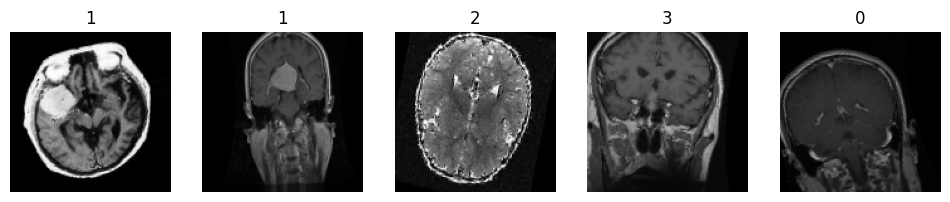

Sınıflar: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [7]:
# 2. Veri Önişleme (Preprocessing)
# Kaggle dataset path’i
dataset_path = "/kaggle/input/brain-tumor-mri-dataset/Training"  # Training klasörü

# Data Augmentation ve rescale işlemleri
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    rotation_range=20,         
    width_shift_range=0.1,     
    height_shift_range=0.1,    
    zoom_range=0.2,            
    horizontal_flip=True,      
    validation_split=0.2       
)

# Eğitim generator’ü
train_generator = train_datagen.flow_from_directory(
    dataset_path,              
    target_size=(128,128),     
    batch_size=32,             
    class_mode='categorical',  
    subset='training',         
    shuffle=True               
)

# Validation generator’ü
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',       
    shuffle=False              
)

# Örnek görselleri göster
images, labels = next(train_generator)
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.show()

# Sınıf isimlerini yazdır
print("Sınıflar:", train_generator.class_indices)

Epoch 1/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.4611 - loss: 1.1699 - val_accuracy: 0.6380 - val_loss: 0.9817
Epoch 2/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.7128 - loss: 0.7102 - val_accuracy: 0.6775 - val_loss: 0.8920


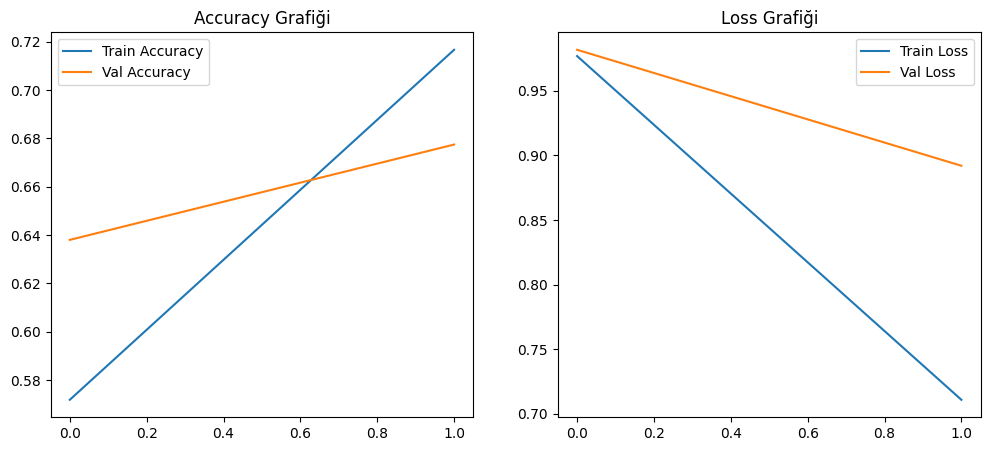

In [14]:
# 3. Modelin Eğitilmesi (Training CNN)

#  CNN modelimizi tanımlama
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),  # 1. Convolution + Pooling
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu'),  # 2. Convolution + Pooling
    MaxPooling2D(2,2),

    Flatten(),                             # Düzleştir
    Dropout(0.3),                           # Overfitting önlemek için
    Dense(64, activation='relu'),           # Fully Connected
    Dense(train_generator.num_classes, activation='softmax')  # Çok sınıflı çıktı
])

#  Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modeli eğitiyoruz (2 epoch)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,     # Hızlı test için
    batch_size=16 # GPU hafızasına göre ayarlanabilir
)

# Modeli kaydetmek
model.save("cnn_quick_test.h5")

# Eğitim sonrası accuracy ve loss grafiklerini çizmek istersen
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Grafiği")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Grafiği")

plt.show()


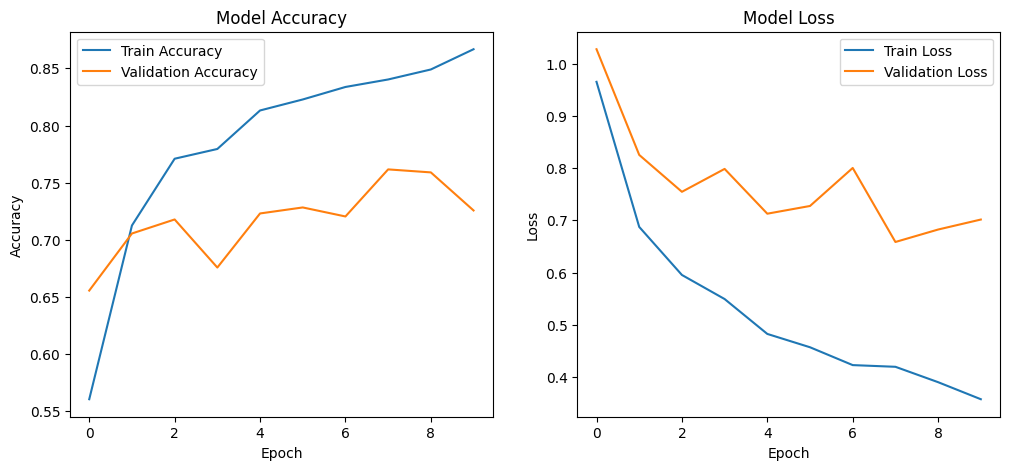

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step


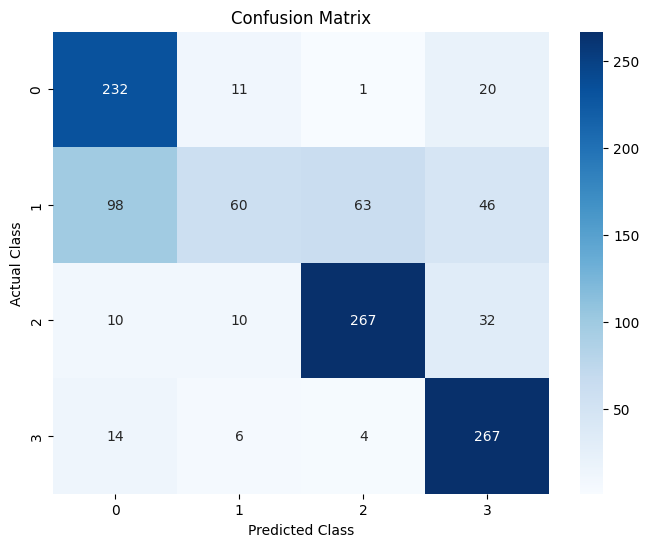

Classification Report:
              precision    recall  f1-score   support

      glioma       0.66      0.88      0.75       264
  meningioma       0.69      0.22      0.34       267
     notumor       0.80      0.84      0.82       319
   pituitary       0.73      0.92      0.81       291

    accuracy                           0.72      1141
   macro avg       0.72      0.71      0.68      1141
weighted avg       0.72      0.72      0.69      1141



In [11]:
# 4. Modelin Değerlendirilmesi (Evaluation & Grad-CAM)

# Accuracy ve Loss Grafikleri
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix ve Classification Report
# Modelin validation verisi üzerindeki tahminlerini alıyoruz
val_generator.reset()  # generator'ı başa al
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


In [16]:

# 5. Hiperparametre Optimizasyonu (Hyperparameter Tuning)
dropouts = [0.3, 0.5]           # Dropout oranı
learning_rates = [0.001, 0.0001] # Learning rate
optimizers = [Adam, SGD]        # Optimizer tipi

# Daha hızlı deneme için epoch sayısını düşük tutum.
epochs = 3
batch_size = 32

# Denemeleri tek tek çalıştır
for dropout_rate, lr, opt_class in itertools.product(dropouts, learning_rates, optimizers):
    print(f"\nTraining model with Dropout={dropout_rate}, Learning rate={lr}, Optimizer={opt_class.__name__}")

    # Modeli tanımla
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    # Modeli derle
    optimizer = opt_class(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Modeli eğit
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        batch_size=batch_size
    )

    # Modeli kaydet 
    model.save(f"cnn_model_dropout{dropout_rate}_lr{lr}_{opt_class.__name__}.h5")



Training model with Dropout=0.3, Learning rate=0.001, Optimizer=Adam
Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.4491 - loss: 1.1650 - val_accuracy: 0.5557 - val_loss: 1.0921
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.7017 - loss: 0.7311 - val_accuracy: 0.6196 - val_loss: 0.9620
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 206ms/step - accuracy: 0.7416 - loss: 0.6351 - val_accuracy: 0.6827 - val_loss: 0.8454

Training model with Dropout=0.3, Learning rate=0.001, Optimizer=SGD
Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 215ms/step - accuracy: 0.2736 - loss: 1.3827 - val_accuracy: 0.2796 - val_loss: 1.3535
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.2852 - loss: 1.3405 - val_accuracy: 0.2796 - val_loss: 1.3406
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.2893 - loss: 1.3242 - val_accuracy: 0.2796 - val_loss: 1.3224

Training model with Dropout=0.3, Learning rate=0.0001, Optimizer=Adam
Epoch 1/3
